<a href="https://colab.research.google.com/github/ydv1412/Customer_segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [1]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler



from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA

In [2]:
df = pd.read_excel('/content/drive/MyDrive/AlmaBetter/Customer_segmentation/Online Retail.xlsx')                 ### Loading dataset

<i>Let's have a look at the dataset

In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


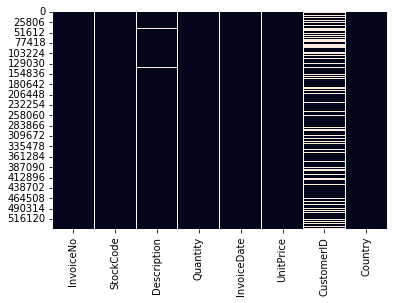

In [ ]:
sns.heatmap(df.isnull(), cbar=False)                                                   ## visualising null points

In [ ]:
# df['CustomerID'] = df['CustomerID'].apply('str')                                     ## changing customerID to str

In [ ]:
(df.isnull().sum()/df.shape[0])*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

<i>We can see that around 24 percent of CustomerID values are missing.

In [ ]:
len(df[df.duplicated()])                                                            ### lets see if our dataset has duplicate rows

5268

<i>Dropping duplicate entries

In [ ]:
df=df.drop_duplicates()
len(df[df.duplicated()])

0

## Missing Value Imputation

<I> Let's impute missing categorical value using most frequent value throughout column

In [ ]:
def categorical_imputation(df,variable):                                               ### function to impute description
  most_frequent_category=df[variable].mode()[0]
  df[variable].fillna(most_frequent_category,inplace=True)

In [ ]:
categorical_imputation(df,'Description')

<I>Let's impute numerical variable using Random Sample Imputation(MCAR) 

In [ ]:
def numeric_imputation(df,variable):                                                   ### function to impute CustomerID
  df[variable+'_imputed']=df[variable]
  random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
  random_sample.index= df[df[variable].isnull()].index
  df.loc[df[variable].isnull(),variable+'_imputed']=random_sample

In [ ]:
numeric_imputation(df , 'CustomerID')

In [ ]:
df.drop(['CustomerID'],axis=1,inplace=True)

In [ ]:
df.drop(['month'],axis=1,inplace=True)

In [ ]:
df.isnull().sum()                                                                      ## rechecking null values

InvoiceNo             0
StockCode             0
Description           0
Quantity              0
InvoiceDate           0
UnitPrice             0
Country               0
CustomerID_imputed    0
dtype: int64

<i>Let's create derived features year, date, month etc. from InvoiceDate


In [ ]:
df['InvoiceDate_year'] = df['InvoiceDate'].dt.year                                     ## year
df['InvoiceDate_month'] = df['InvoiceDate'].dt.month                                   ## month
df['InvoiceDate_day'] = df['InvoiceDate'].dt.day                                       ## day
df['InvoiceDate_hour'] = df['InvoiceDate'].dt.hour                                     ## hour
df['InvoiceDate_minute'] = df['InvoiceDate'].dt.minute                                 ## minute
df['InvoiceDate_second'] = df['InvoiceDate'].dt.second                                 ## second

In [ ]:
df.shape

(536641, 14)

## EDA

<i>Let's see how many customers belong to different countries countries.

In [ ]:
df2 = df['Country'].value_counts()                                                         
df2 = pd.DataFrame(df2)
print(df2.shape[0])

38


<i> Customers from 38 countries have bought from our online retail shop.

Text(0, 0.5, 'Number of customers')

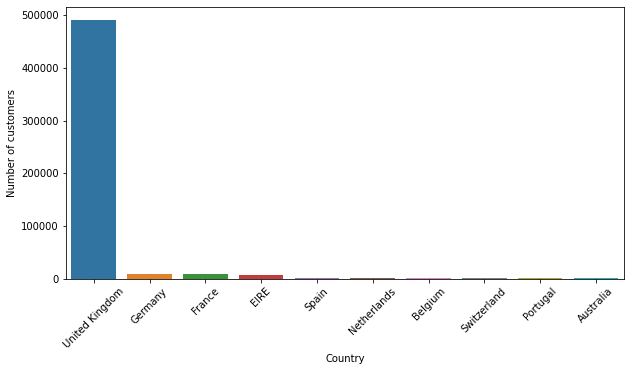

In [ ]:
# top 10 countries wrt number of customers
plt.figure(figsize=(10,5))
Country=df2.head(10)
ax = sns.barplot(y='Country',x=Country.index, data=Country)                                ## barplot 
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Number of customers")

Text(0, 0.5, 'Number of customers')

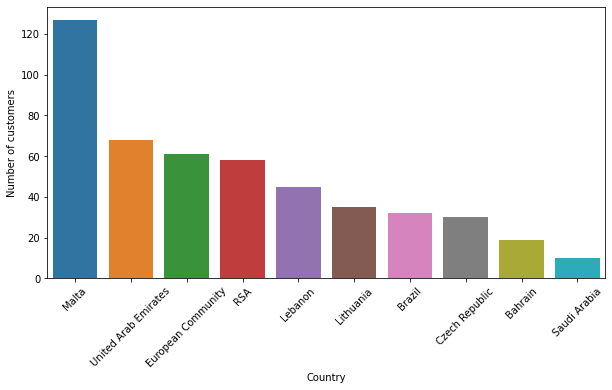

In [ ]:
### bottom 10 countries wrt number of customers
plt.figure(figsize=(10,5))
Country=df2.tail(10)
ax = sns.barplot(y='Country',x=Country.index, data=Country)                                    ## barplot
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Number of customers")

<i>We can see that most of the customers are from United states and least from Saudi Arabia

<i>Let's create another feature amount

In [ ]:
df['Amount'] = df['Quantity'] * df['UnitPrice']                                               ## new feature

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID_imputed,InvoiceDate_year,InvoiceDate_month,InvoiceDate_day,InvoiceDate_hour,InvoiceDate_minute,InvoiceDate_second,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850.0,2010,12,1,8,26,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0,2010,12,1,8,26,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850.0,2010,12,1,8,26,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0,2010,12,1,8,26,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0,2010,12,1,8,26,0,20.34


<i>Let's see which country customers spent maximum and which country customers spent minimum on our retail shop.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

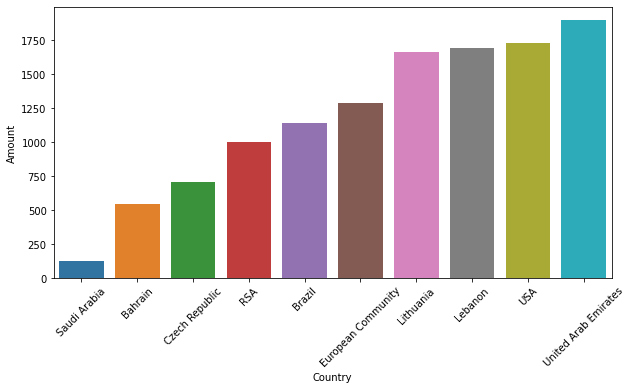

In [ ]:
###bottom 10 countries wrt amount spent on our store
df_amount = df.groupby(['Country'])['Amount'].sum().reset_index().sort_values(by = 'Amount',ascending = True)            
plt.figure(figsize=(10,5))
Country=df_amount.head(10)
ax = sns.barplot(x='Country',y=Country.Amount, data=Country)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

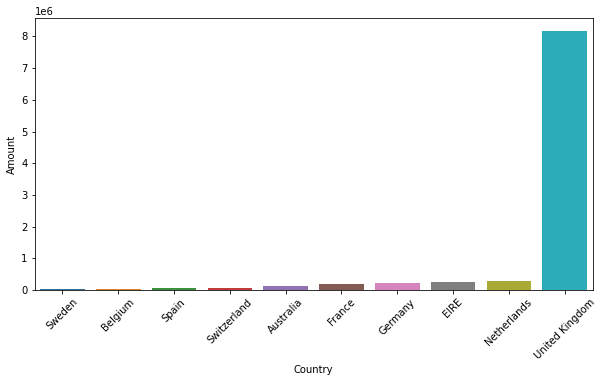

In [ ]:
### maximum money spent by country wrt money spent on our shop
plt.figure(figsize=(10,5))
Country=df_amount.tail(10)
ax = sns.barplot(x='Country',y=Country.Amount, data=Country)
plt.xticks(rotation=45)

<i>Let's convert InvoiceDate to a proper DateTime object to perform certain operations

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')                     ### DateTime objective

<i>Let's see in which month customers spend more

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

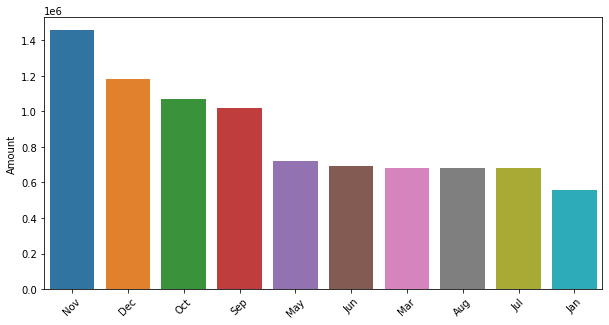

In [ ]:
month_list = pd.Series(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])      ### month list
 
df['month'] = df['InvoiceDate'].apply(lambda x: x.month)                                               ### creating a column month
df['month'] = df['month'].astype('int64')
df_monthly_amount = df.groupby('month')['Amount'].sum().reset_index().sort_values(by = 'Amount',ascending = False)
plt.figure(figsize=(10,5))
month=df_monthly_amount.head(10)
ax = sns.barplot(x=month_list[month.month-1],y='Amount', data=month)
plt.xticks(rotation=45)

<i> Let's see how many Invoice generated get cancelled.

In [ ]:
## counting the number of invoices starting with c
df['InvoiceNo'] = df['InvoiceNo'].astype('str')                                         
df_cancelled = df[df['InvoiceNo'].str.startswith('C')]                               
print("Number of invoices which are cancelled are {}".format(df_cancelled.shape[0]))

Number of invoices which are cancelled are 9251


([<matplotlib.patches.Wedge at 0x7f2f33b9cc50>,
 [Text(1.0984184498800915, 0.058965320002666764, 'Cancelled'),
  Text(-1.09841844919, -0.0589653328578362, 'Not_Cancelled')],
 [Text(0.5991373362982317, 0.032162901819636415, '2%'),
  Text(-0.5991373359218182, -0.032162908831547016, '98%')])

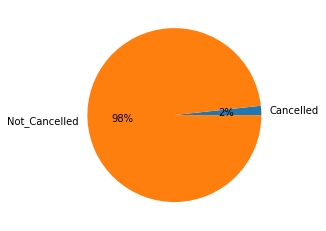

In [ ]:
##Pie chart
Cancelled_or_Not=pd.DataFrame({'Invoices':['Cancelled','Not_Cancelled'],'value':[9251,532658]})
plt.pie(Cancelled_or_Not.value,labels = Cancelled_or_Not.Invoices , autopct='%.0f%%' ) 

<i> We can see that two percent of total invoices gets cancelled

<i>Let's see how many customers return to our shop after purchasing once.

In [ ]:
df_freq = df.groupby('CustomerID_imputed')['InvoiceNo'].count().reset_index()                            ## frequency of customer
df_freq = pd.DataFrame(df_freq)
df_freq.columns = ['CustomerID_imputed' , 'Freq']                                                        ## new df

In [ ]:
return_no_return = df_freq['Freq'].apply(lambda x: 0 if x==1 else 1)                                     

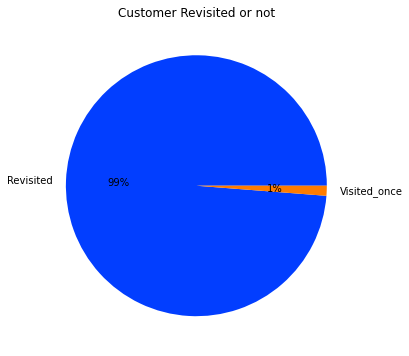

In [ ]:
plt.figure(figsize = (6,6))
colors = sns.color_palette('bright')[0:5]   ## setting colour list
plt.pie(return_no_return.value_counts(),labels = ['Revisited' , 'Visited_once'] ,colors = colors, autopct='%.0f%%' )             #### plotting pie
plt.title('Customer Revisited or not')
plt.show()   

<B> Univariate Analysis

In [ ]:
numerical_columns=list(df.select_dtypes(['int64','float64']).columns)                        ## numerical features
numerical_features=pd.Index(numerical_columns)
numerical_features

Index(['Quantity', 'UnitPrice', 'CustomerID_imputed', 'InvoiceDate_year',
       'InvoiceDate_month', 'InvoiceDate_day', 'InvoiceDate_hour',
       'InvoiceDate_minute', 'InvoiceDate_second', 'Amount', 'month'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


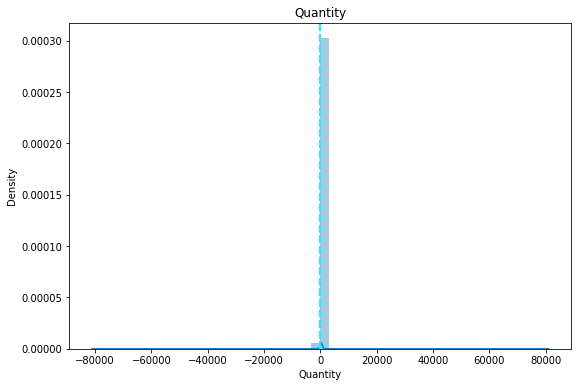

Skewness : -0.2639207787329176
Kurtosis : 118645.54455234332


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


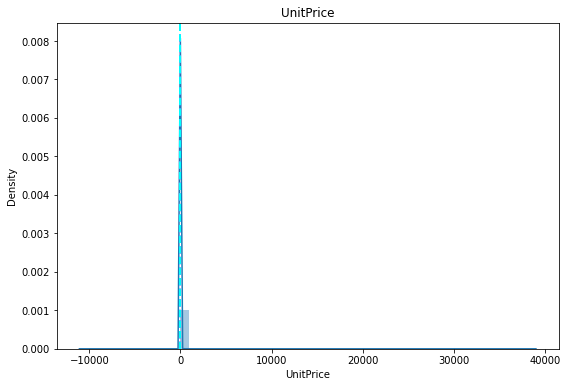

Skewness : 185.60044812920344
Kurtosis : 58433.135910585086


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


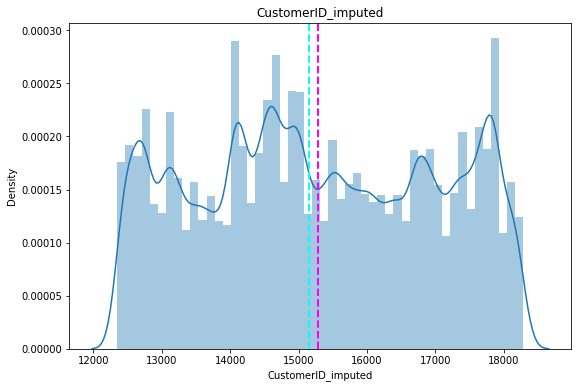

Skewness : 0.03468049946828383
Kurtosis : -1.179793510437348


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


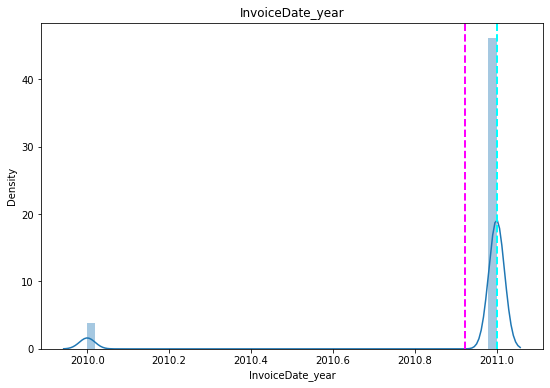

Skewness : -3.1413170786444153
Kurtosis : 7.867902311346793


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


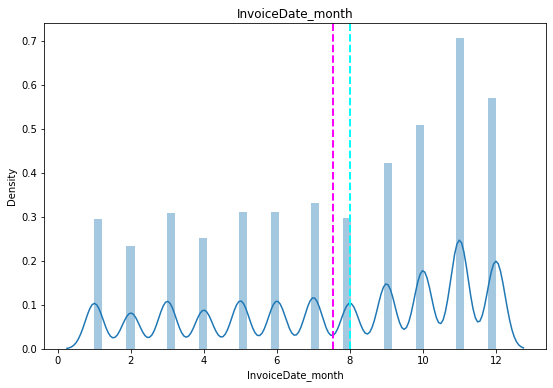

Skewness : -0.4112397637662981
Kurtosis : -1.121688905682585


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


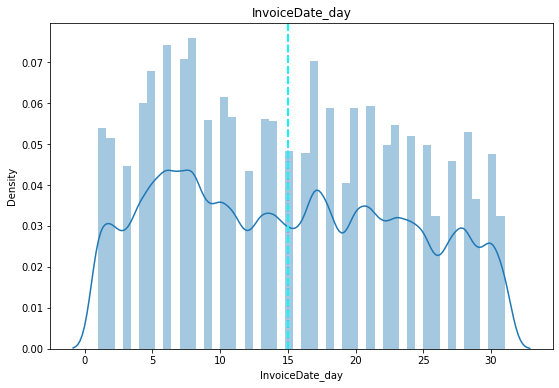

Skewness : 0.1425060392658862
Kurtosis : -1.1573667360751423


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


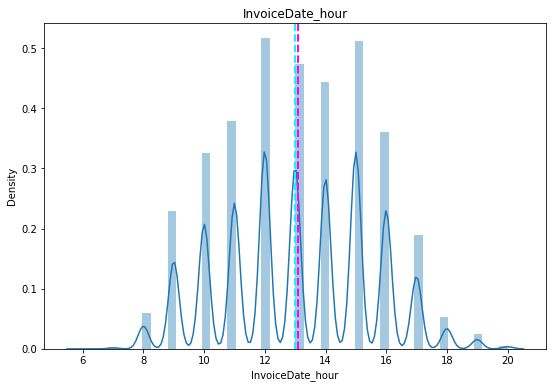

Skewness : 0.002850657774814659
Kurtosis : -0.6944981623468869


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


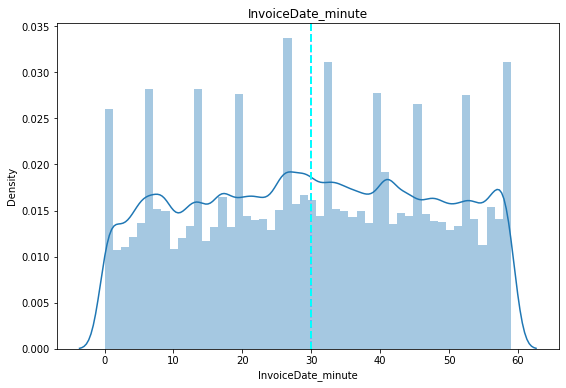

Skewness : -0.02534037213860687
Kurtosis : -1.136943576846362


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


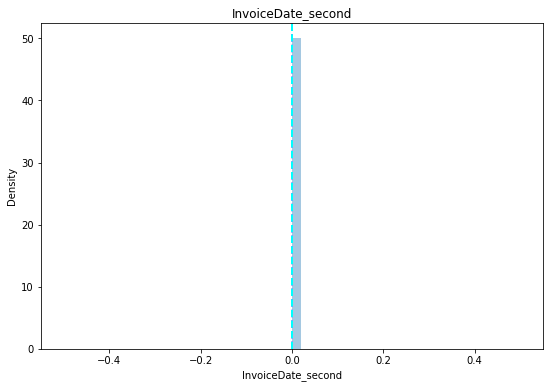

Skewness : 0
Kurtosis : 0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


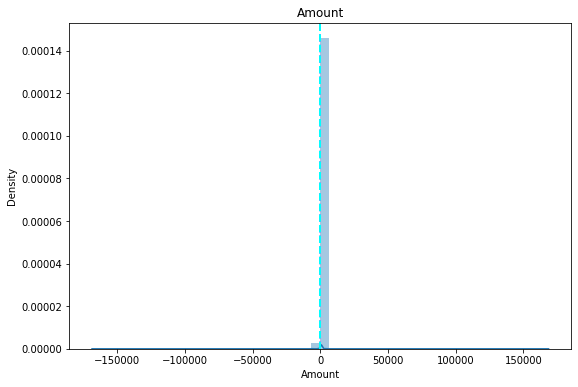

Skewness : -0.9607337379673053
Kurtosis : 149742.8594160145


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


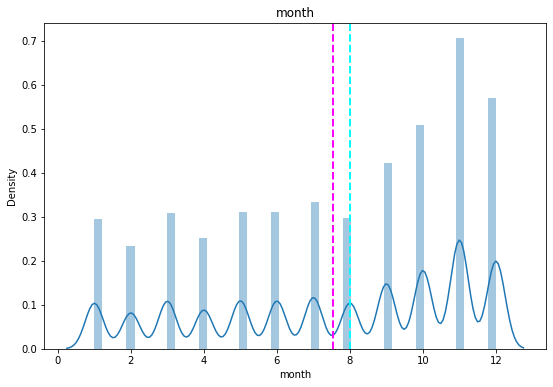

Skewness : -0.4112397637662981
Kurtosis : -1.121688905682585


In [ ]:
#plotting a PDF plot for each numerical feature count with Dist Plot
for col in numerical_features:
  fig=plt.figure(figsize=(9,6))
  ax=fig.gca()
  feature= (df[col])
  sns.distplot(df[col])
  ax.axvline(feature.mean(),color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(),color='cyan', linestyle='dashed', linewidth=2)
  ax.set_title(col)
  plt.show()
  print( "Skewness :",df[col].skew())                                                   ### skewness
  print( "Kurtosis :",df[col].kurt())                                                   ## kurtosis

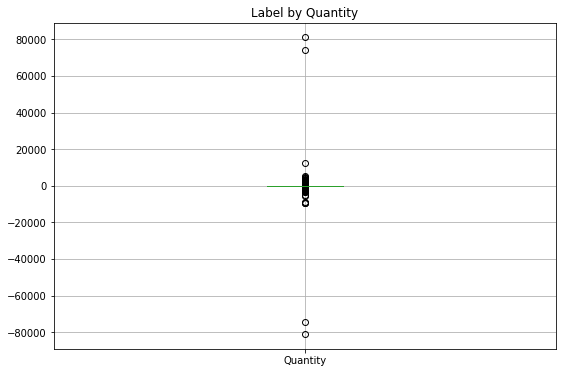

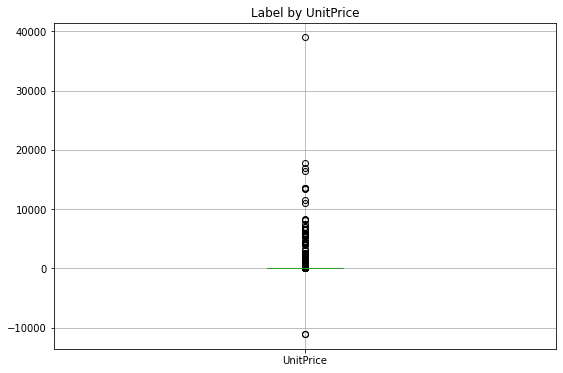

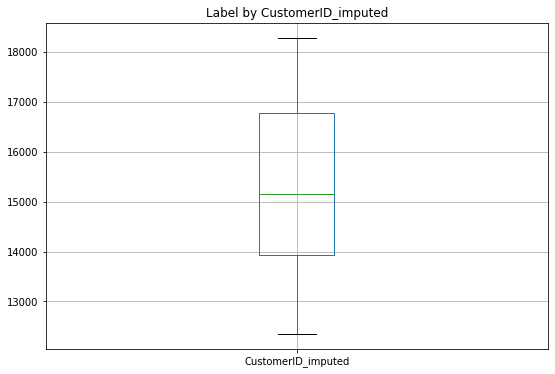

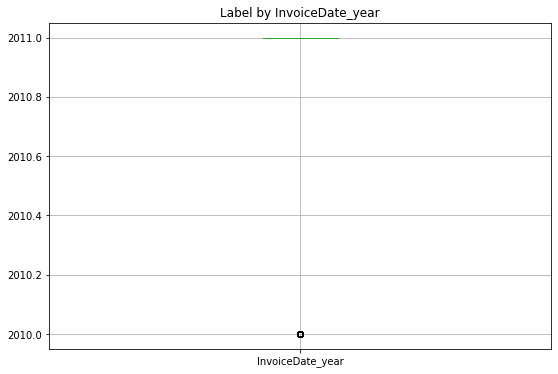

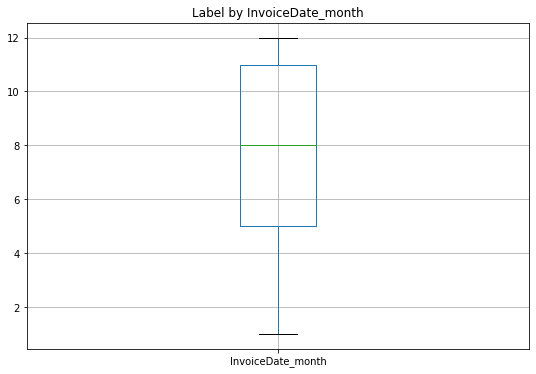

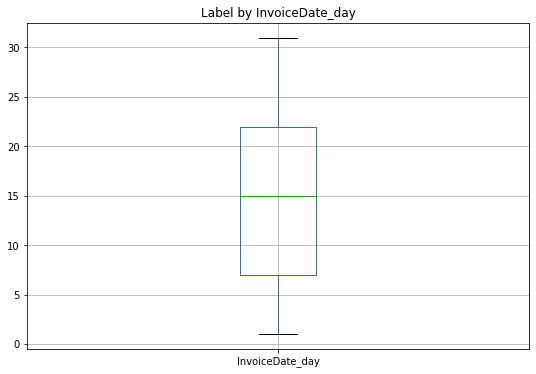

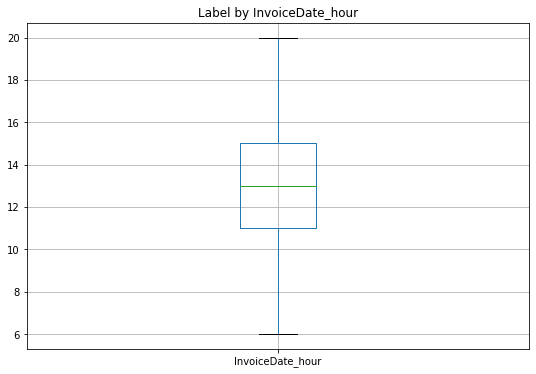

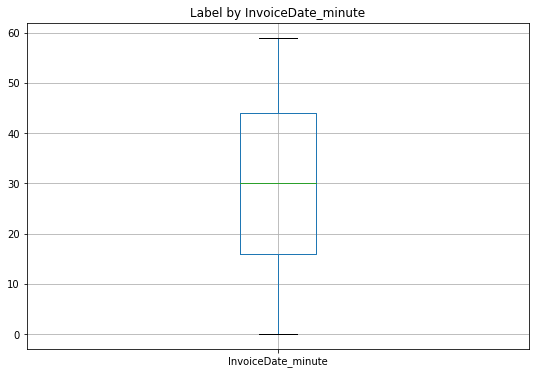

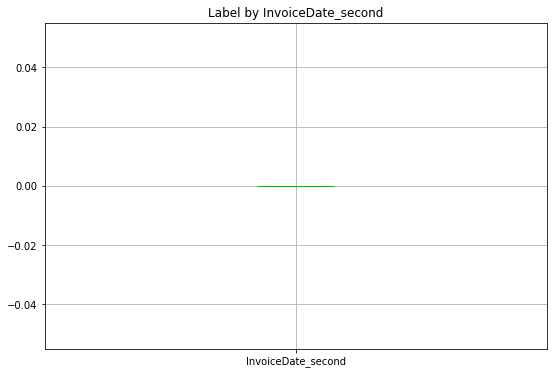

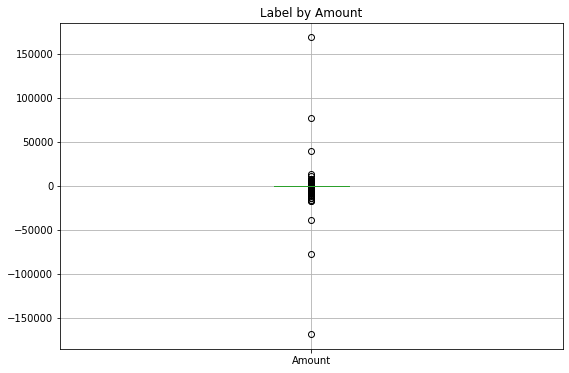

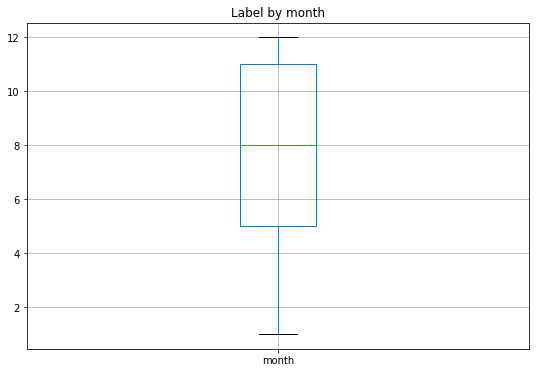

In [ ]:
## box plot for all numerical features

for col in numerical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(col)
    ax.set_title('Label by ' + col)
plt.show()

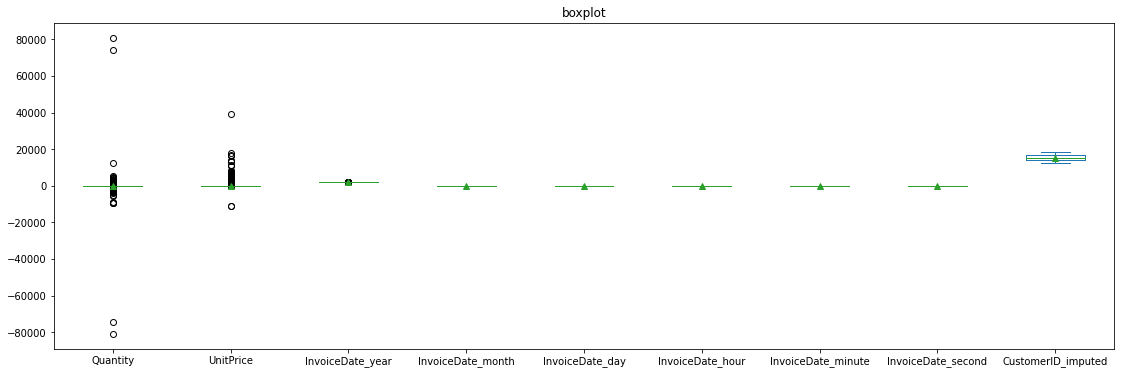

In [ ]:
plt.rcParams['figure.figsize']=(19,6)
ax = df[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 
       'UnitPrice', 'Country', 'InvoiceDate_year', 'InvoiceDate_month',
       'InvoiceDate_day', 'InvoiceDate_hour', 'InvoiceDate_minute',
       'InvoiceDate_second', 'CustomerID_imputed']].plot(kind='box', title='boxplot', showmeans=True)

plt.show()

<i>Categorical Features

In [ ]:
df['Country'] = df['Country'].astype('str')
df['Description'] = df['Description'].astype('str')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


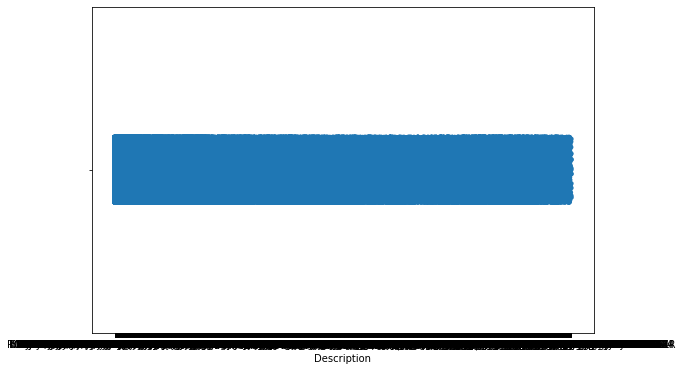

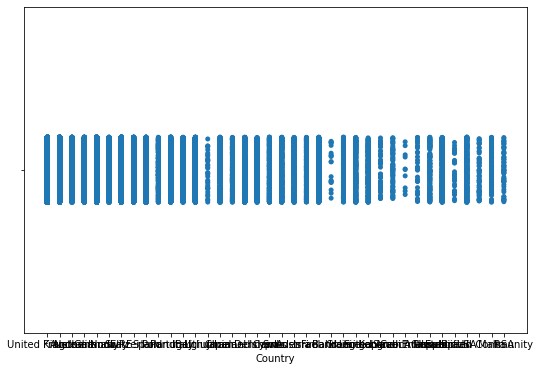

In [ ]:
for col in ['Description', 'Country']:
  fig=plt.figure(figsize=(9,6))
  sns.stripplot(df[col])

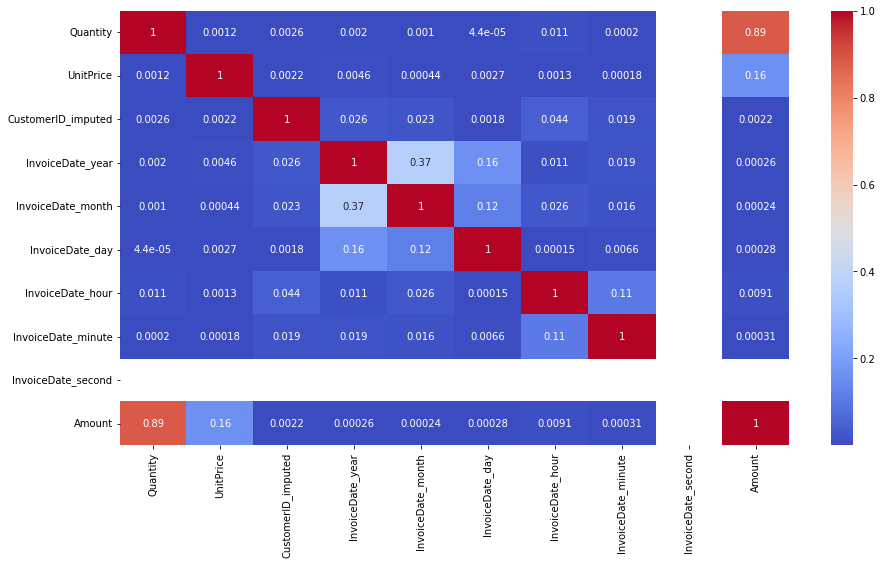

In [ ]:
## Correlation
plt.figure(figsize=(15,8))
correlation=df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')                                    

###<h1>RFM Table<h1>
###R (Recency): Number of days since last purchase

###F (Frequency): Number of tracsactions

###M (Monetary): Total amount of transactions (revenue contributed)

In [ ]:
df_mon = df.groupby('CustomerID_imputed')['Amount'].sum().reset_index()                                   ## total amount spent
df_mon = pd.DataFrame(df_mon)
# df_mon.columns = ['CustomerID_imputed' , 'Amount']
df_mon.columns = ['CustomerID_imputed' , 'Monetary']

In [ ]:
df2 = df_mon.merge(df_freq,how='inner',on=['CustomerID_imputed'])                                          ### merging datasets rowwise

<i>Let's calculate the recency of each customer

In [ ]:
max_date = df['InvoiceDate'].max()                                                                 ## last date
df['diff'] = max_date - df['InvoiceDate']                                                          ## diff

In [ ]:
df_recen = df.groupby('CustomerID_imputed')['diff'].min().reset_index()                           # diff between last invoice date and last date
df_recen = pd.DataFrame(df_recen)
df_recen.columns = ['CustomerID_imputed' , 'recen']

In [ ]:
df2 = df2.merge(df_recen,how='inner',on=['CustomerID_imputed'])                                          ## merging recency and monerary dataset

In [ ]:
df2.head()

,CustomerID_imputed,Monetary,Freq,recen
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4920.27,242,0 days 02:47:00
2,12348.0,1881.64,41,8 days 21:37:00
3,12349.0,2119.51,100,2 days 20:24:00
4,12350.0,361.62,21,134 days 21:34:00


In [ ]:
df2['recen'] = df2['recen'].dt.days                                                        ## extract exact days

In [ ]:
# df2.head()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


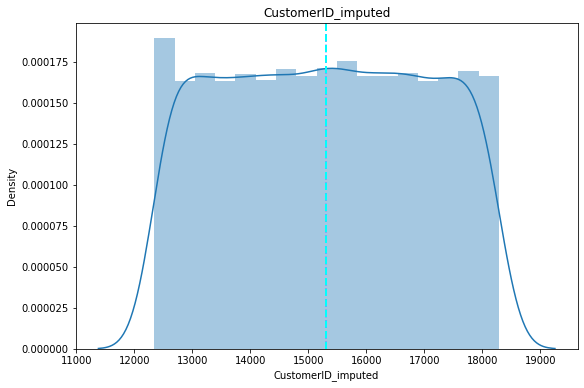

Skewness : 0.0009180495309382999
Kurtosis : -1.1957933267235914


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


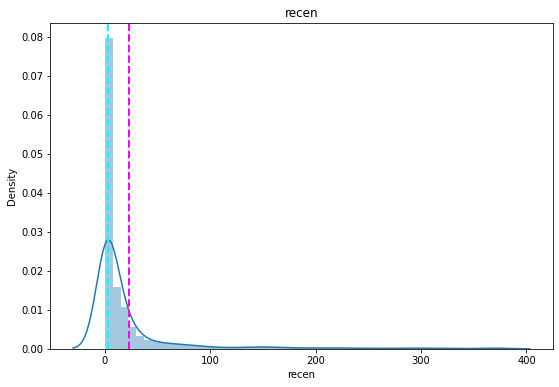

Skewness : 3.9203958367540337
Kurtosis : 17.009681639054214


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


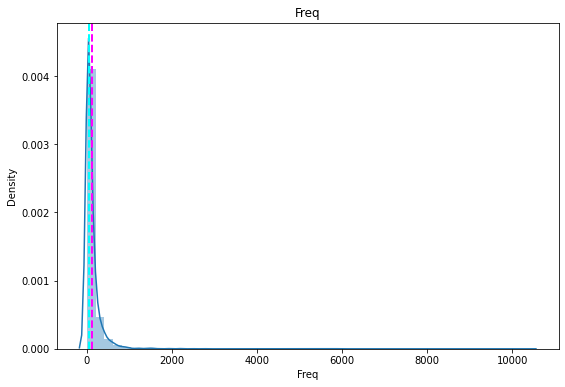

Skewness : 18.024998543491865
Kurtosis : 479.2147504343589


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


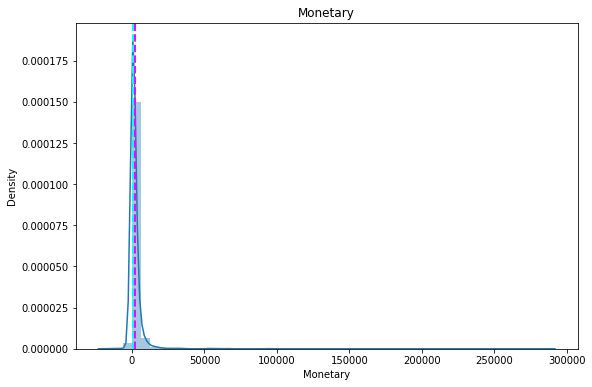

Skewness : 20.0488921215683
Kurtosis : 532.0924658304367


In [ ]:
#plot a bar plot for each numerical feature count with Dist Plot (Car_ID) in RFM table
for col in ["CustomerID_imputed",'recen','Freq','Monetary']:
  fig=plt.figure(figsize=(9,6))
  ax=fig.gca()
  feature= (df2[col])
  sns.distplot(df2[col])
  ax.axvline(feature.mean(),color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(),color='cyan', linestyle='dashed', linewidth=2)
  ax.set_title(col)
  plt.show()
  print( "Skewness :",df2[col].skew())
  print( "Kurtosis :",df2[col].kurt())

<b>Box Plot

Text(0.5, 0, 'Attributes')

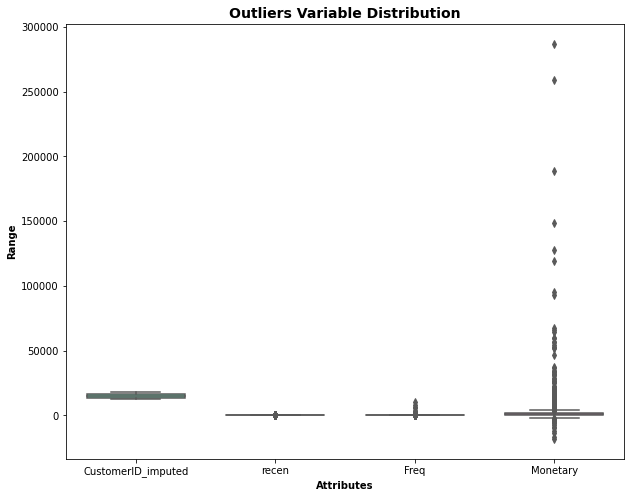

In [ ]:
### box plot for features of RFM table
attributes = ['CustomerID_imputed','recen','Freq','Monetary']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df2[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

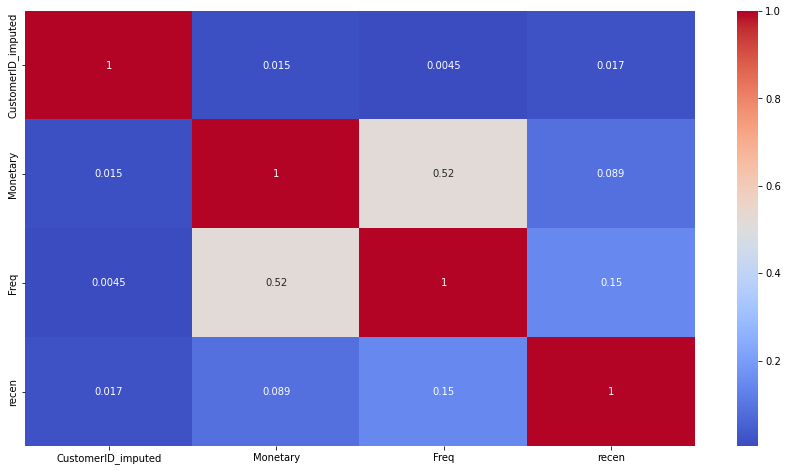

In [ ]:
## Correlation
plt.figure(figsize=(15,8))
correlation=df2.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

<h1>Handling Outliers

In [ ]:
df_1=df.copy()                                                                            ## creating a copy

def iqr_symmetric_impute(df,variable):                                                     ##function to remove outliers
  lower_bridge=df[variable].mean()-3*(df[variable].std())                                  ##IQR
  upper_bridge=df[variable].mean()+3*(df[variable].std())                                  #IQR
  df.loc[df[variable]>=upper_bridge,variable]=upper_bridge
  df.loc[df[variable]<=lower_bridge,variable]=lower_bridge

In [ ]:
for variable in ['Quantity',
       'UnitPrice']:                                                                     ## removing outlier from original dataset
  iqr_symmetric_impute(df_1,variable)

In [ ]:
df_rfm = df2.copy()                                                                     ## removing outliers form RFM dataset

for variable in ['recen','Monetary','Freq']:
  iqr_symmetric_impute(df_rfm,variable)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


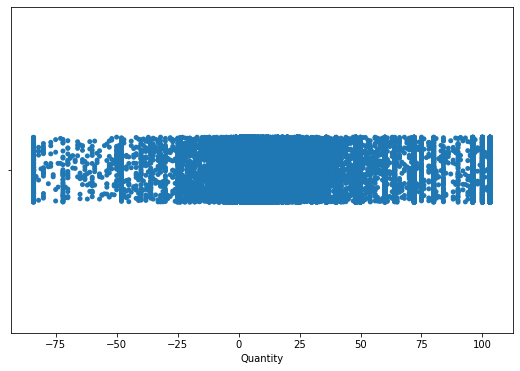

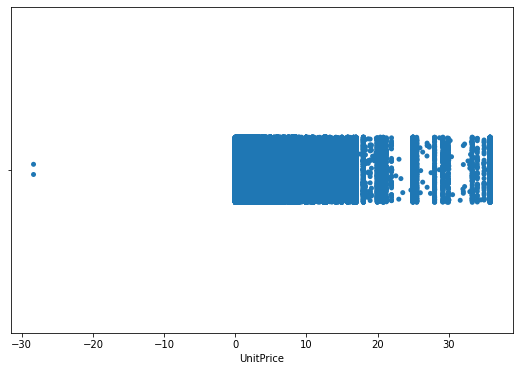

In [ ]:
## strip plot after outliers removal
for col in ['Quantity',
       'UnitPrice']:
  fig=plt.figure(figsize=(9,6))
  sns.stripplot(df_1[col])

<i>Let's encode Categorical feature

In [ ]:
#### commented
df_2=df_1[['Quantity',                                                                     ## numerical feature
       'UnitPrice', 'Country', 'InvoiceDate_year', 'InvoiceDate_month',
       'InvoiceDate_day', 'InvoiceDate_hour', 'InvoiceDate_minute',
       'InvoiceDate_second', 'CustomerID_imputed' , 'Description']]                           ## categorical feature
df_2

,Quantity,UnitPrice,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_day,InvoiceDate_hour,InvoiceDate_minute,InvoiceDate_second,CustomerID_imputed,Description
0,6.0,2.55,United Kingdom,2010,12,1,8,26,0,17850.0,WHITE HANGING HEART T-LIGHT HOLDER
1,6.0,3.39,United Kingdom,2010,12,1,8,26,0,17850.0,WHITE METAL LANTERN
2,8.0,2.75,United Kingdom,2010,12,1,8,26,0,17850.0,CREAM CUPID HEARTS COAT HANGER
3,6.0,3.39,United Kingdom,2010,12,1,8,26,0,17850.0,KNITTED UNION FLAG HOT WATER BOTTLE
4,6.0,3.39,United Kingdom,2010,12,1,8,26,0,17850.0,RED WOOLLY HOTTIE WHITE HEART.
...,...,...,...,...,...,...,...,...,...,...,...
541904,12.0,0.85,France,2011,12,9,12,50,0,12680.0,PACK OF 20 SPACEBOY NAPKINS
541905,6.0,2.10,France,2011,12,9,12,50,0,12680.0,CHILDREN'S APRON DOLLY GIRL
541906,4.0,4.15,France,2011,12,9,12,50,0,12680.0,CHILDRENS CUTLERY DOLLY GIRL
541907,4.0,4.15,France,2011,12,9,12,50,0,12680.0,CHILDRENS CUTLERY CIRCUS PARADE


In [ ]:
df_final=pd.get_dummies(df_2)                                                    ### one hot encoding

In [ ]:
df_final

,Quantity,UnitPrice,InvoiceDate_year,InvoiceDate_month,InvoiceDate_day,InvoiceDate_hour,InvoiceDate_minute,InvoiceDate_second,CustomerID_imputed,Country_Australia,...,Description_wrongly coded 20713,Description_wrongly coded 23343,Description_wrongly coded-23343,Description_wrongly marked,Description_wrongly marked 23343,Description_wrongly marked carton 22804,Description_wrongly marked. 23343 in box,Description_wrongly sold (22719) barcode,Description_wrongly sold as sets,Description_wrongly sold sets
0,6.0,2.55,2010,12,1,8,26,0,17850.0,0,...,0,0,0,0,0,0,0,0,0,0
1,6.0,3.39,2010,12,1,8,26,0,17850.0,0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,2.75,2010,12,1,8,26,0,17850.0,0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,3.39,2010,12,1,8,26,0,17850.0,0,...,0,0,0,0,0,0,0,0,0,0
4,6.0,3.39,2010,12,1,8,26,0,17850.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,12.0,0.85,2011,12,9,12,50,0,12680.0,0,...,0,0,0,0,0,0,0,0,0,0
541905,6.0,2.10,2011,12,9,12,50,0,12680.0,0,...,0,0,0,0,0,0,0,0,0,0
541906,4.0,4.15,2011,12,9,12,50,0,12680.0,0,...,0,0,0,0,0,0,0,0,0,0
541907,4.0,4.15,2011,12,9,12,50,0,12680.0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_final.shape

(536641, 4270)

<i>We can see that the dimension of df_final is very high. Let's use dimensionality reduction technique PCA to reduce the dimension of our dataset.

<h1>Dimensionality Reduction

<i>Firstly let's standardise the dataset.

In [ ]:
df_final2 = df_final.sample(n=50000 , random_state = 42)                                  ### 50000  samples

In [ ]:
df_final2.shape

(50000, 4270)

<h1> Standardising dataset

In [ ]:
sc = StandardScaler()                                                                  ### standardising dataset
  
X_train = sc.fit_transform(df_final2)

In [ ]:
X_train.shape                                                                             ## shape

(50000, 4270)

<h1>Dimensionality Reduction

In [ ]:
pca = PCA(n_components = 4)                                                               ### pca
  
X_train = pca.fit_transform(X_train)
  
explained_variance = pca.explained_variance_ratio_                                          ### variance explained by features

In [ ]:
explained_variance

array([0.00070364, 0.00058572, 0.00048891, 0.00035666])

In [ ]:
X=X_train.copy()

# Clustering

1.Centroid Based Clustering(Kmeans)

In [ ]:
sil = []
kmax = 10                                                                              

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax)):
  kmeans = KMeans(n_clusters = k).fit(X)                                              ### k-Means
  labels = kmeans.labels_                                                              ## cluster ID's
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

100%|██████████| 8/8 [03:43<00:00, 27.89s/it]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


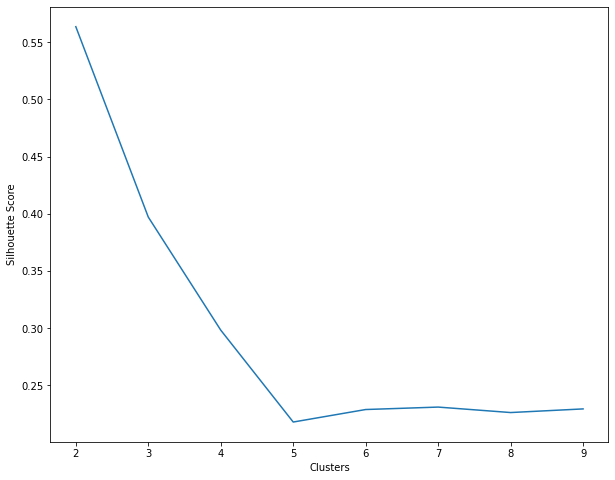

In [ ]:
## knee method

xs2 = [i for i in range(2,kmax)]
sns.lineplot(xs2,sil)                                                                  ### line plot
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")
plt.show()

<I>The silhouette_score is maximum around n_clusters = 3. Lets cluster at n_clusters = 3 and visualise the results

In [ ]:
df5 = X.copy()                                                                     ## copying dataset
df5 = pd.DataFrame(df5)

In [ ]:
clusterer = KMeans(n_clusters=3,max_iter=1000, random_state=10)                    ## n_clusters = 3
cluster_labels = clusterer.fit_predict(df5)                                         ### cluster labels
print(cluster_labels)

[0 0 2 ... 0 0 0]


<i>Let's visualise the clusters on a 2d plot.

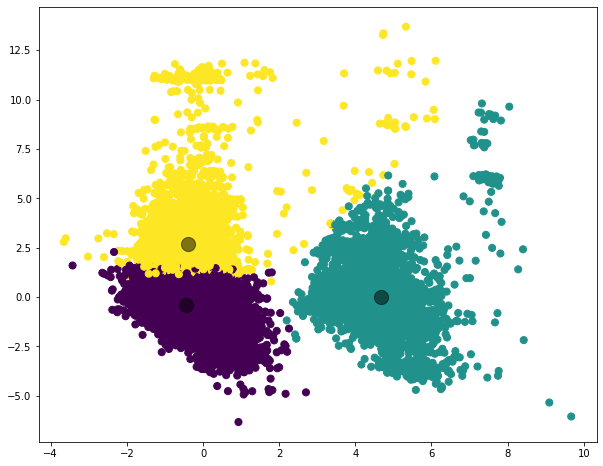

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=50, cmap='viridis')                 ## scatter plot

centers = clusterer.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<i> Let's checck at k=4 too

In [ ]:
clusterer = KMeans(n_clusters=4,max_iter=1000, random_state=10)
cluster_labels = clusterer.fit_predict(df5)
print(cluster_labels)

[3 3 2 ... 0 3 3]


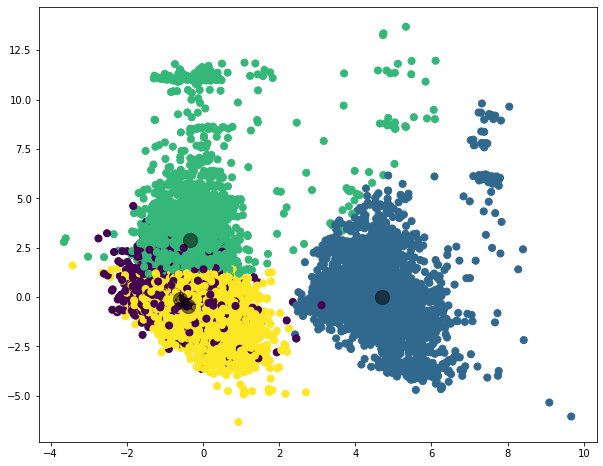

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=50, cmap='viridis')

centers = clusterer.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

<i>K=5

[3 0 4 ... 2 3 3]


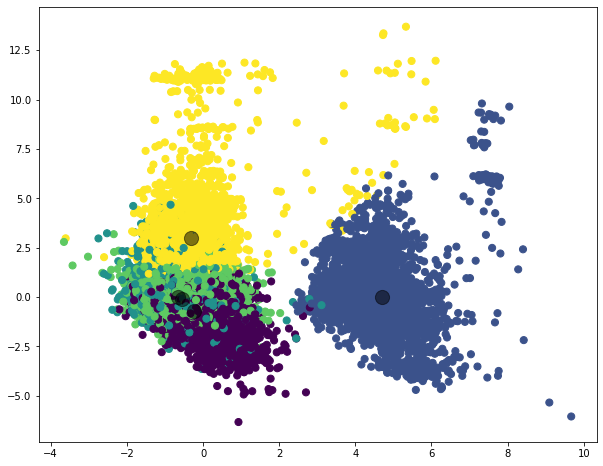

In [ ]:
clusterer = KMeans(n_clusters=5,max_iter=1000, random_state=10)
cluster_labels = clusterer.fit_predict(df5)
print(cluster_labels)
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=50, cmap='viridis')

centers = clusterer.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

RFM clustering(K-Means)

<i>Standerdising data

In [ ]:
sc = StandardScaler()
df_rfm = sc.fit_transform(df_rfm)                                                           ### standardising

In [ ]:
df_rfm.shape

(4372, 4)

In [ ]:
df_rfm = pd.DataFrame(df_rfm , columns = ['Customer_Id_imputed' , 'recen' , 'Freq' ,'Monetary' ])             ### creating df from narray

In [ ]:
df_rfm.head()

,Customer_Id_imputed,recen,Freq,Monetary
0,-1.715067,-0.538671,-0.696088,3.993962
1,-1.714486,0.868437,0.815467,-0.496314
2,-1.713906,-0.000556,-0.450461,-0.300666
3,-1.713325,0.067470,-0.078870,-0.447402
4,-1.712744,-0.435255,-0.576424,2.780779


In [ ]:
clusterer = KMeans(n_clusters=3,max_iter=1000, random_state=10)                                        ### numbe rof clusters  = 3
cluster_labels = clusterer.fit_predict(df_rfm)
print(cluster_labels)

[2 0 0 ... 0 1 0]


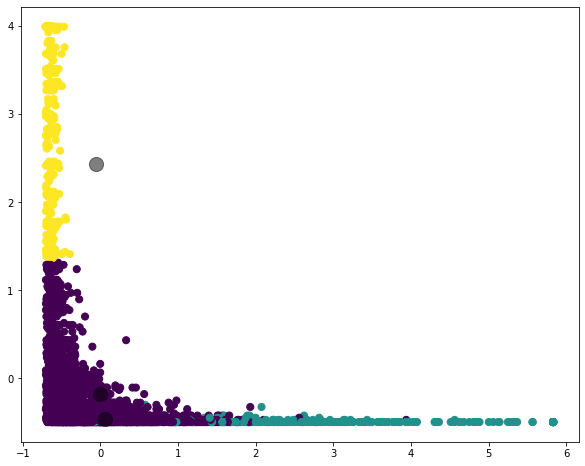

In [ ]:
## 2d plot
plt.scatter(df_rfm['Freq'], df_rfm['Monetary'], c=cluster_labels, s=50, cmap='viridis')

centers = clusterer.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
df2_ = df_rfm.copy()                                                           ## copying

<i>Let's plot boxplot after clustering RFM table

   CustomerID_imputed  Monetary  Freq  recen
0             12346.0      0.00     2    325
1             12347.0   4920.27   242      0
2             12348.0   1881.64    41      8
3             12349.0   2119.51   100      2
4             12350.0    361.62    21    134
5             12352.0   1797.90   127      8
6             12353.0    105.58     5     98
7             12354.0   1267.47    74      7
8             12355.0    500.08    20      0
9             12356.0   2947.85    78      0


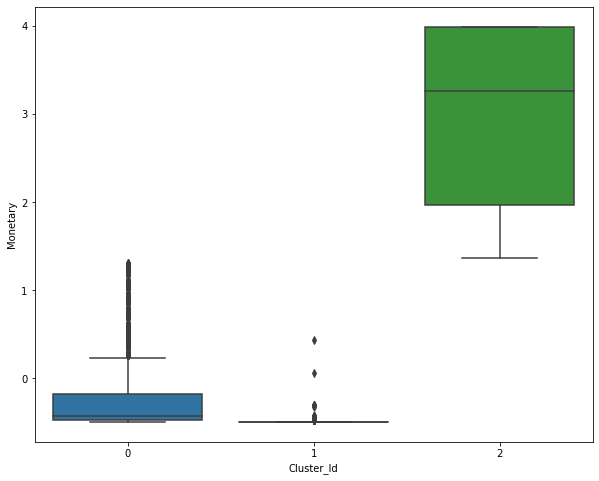

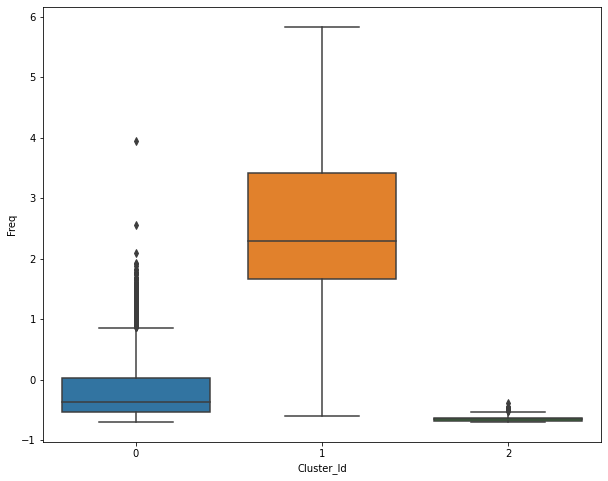

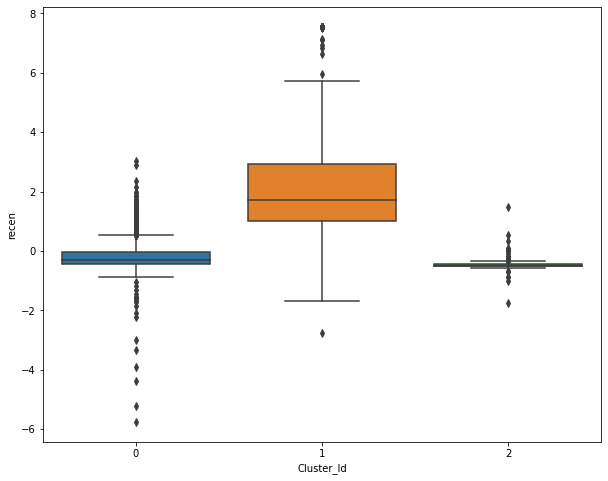

In [ ]:
df2_['Cluster_Id'] = cluster_labels
print(df2.head(10))

# Box plot to visualize Cluster Id vs MonetaryValue

sns.boxplot(x='Cluster_Id', y='Monetary', data=df2_)
plt.show()

# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Freq', data=df2_)
plt.show()

# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='recen', data=df2_)
plt.show()


2. Hierarchial clustering


<i>Due to limited hardware capacity using only 1000 data points for clustering

In [ ]:
X = X[:1000]                                                                             ### slicing 1000 points

Method :Single

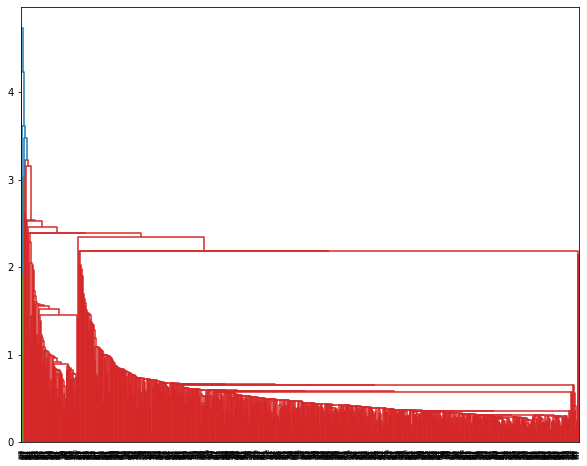

In [ ]:
mergings = linkage(X, method="single", metric='euclidean')                                ### single linkage
dendrogram(mergings)
plt.show()

Method:complete

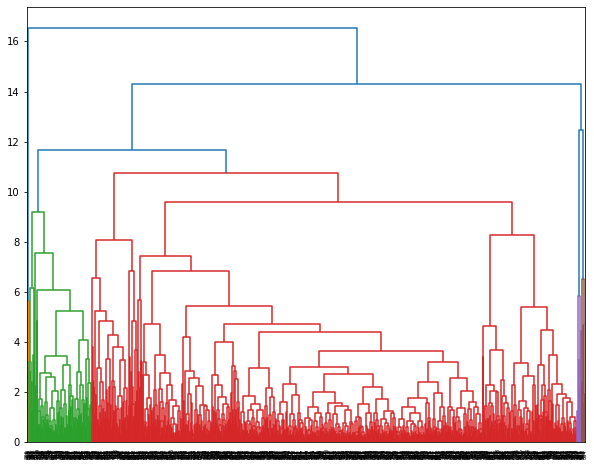

In [ ]:
mergings = linkage(X, method="complete", metric='euclidean')                                     ### complete linkage
dendrogram(mergings)
plt.show()

Method : Average

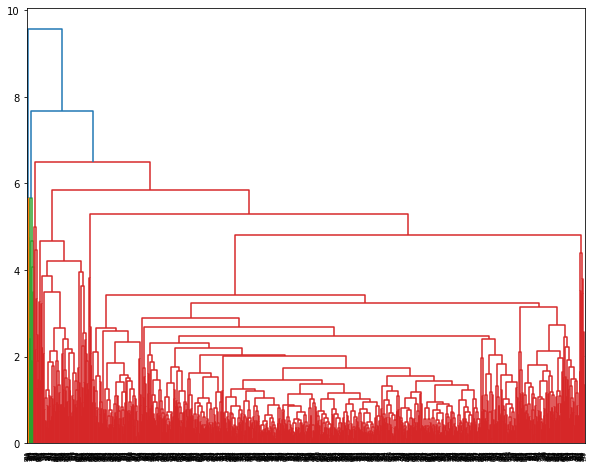

In [ ]:
mergings = linkage(X, method="average", metric='euclidean')                                           ### average linkage
dendrogram(mergings)
plt.show()

In [ ]:
df8 = X.copy()                                                                       ## Copying dataset
df8 = pd.DataFrame(df8)

<i>Let's cluster using average linkage

In [ ]:
k=3
cluster_labels = cut_tree(mergings, n_clusters=k).reshape(-1, )                                ### reducing dimension by one
df8['Cluster_Labels'] = cluster_labels
df8.head()

,0,1,2,3,Cluster_Labels
0,-0.253107,0.717144,-0.790809,0.173316,0
1,-0.736696,-0.273928,-0.433652,-1.168239,0
2,-0.240647,1.507513,-0.930273,-0.775199,0
3,4.739282,0.563613,-0.325044,-0.027117,0
4,0.296424,-0.693524,-1.271432,-0.910224,0


In [ ]:
## visualising in 3d

df8["Cluster_Labels"] = df8["Cluster_Labels"].astype(str)                                     #convert to string
fig = px.scatter_3d(X, x = X[:,0], y=X[:,1], z=X[:,2],
              color=cluster_labels)
fig.show()

In [ ]:
print("when hierarchial clustering with n_clusters = 3 score is {}".format(silhouette_score(X , cluster_labels, metric = 'euclidean')))

when hierarchial clustering with n_clusters = 3 score is 0.569702456706603


3.Density Based Clustering

In [ ]:
neigh = NearestNeighbors(n_neighbors = 6)                                             ## finding 6 nearest neighbours to each datapoints
nbrs = neigh.fit(X)
distances , indices = nbrs.kneighbors(X)

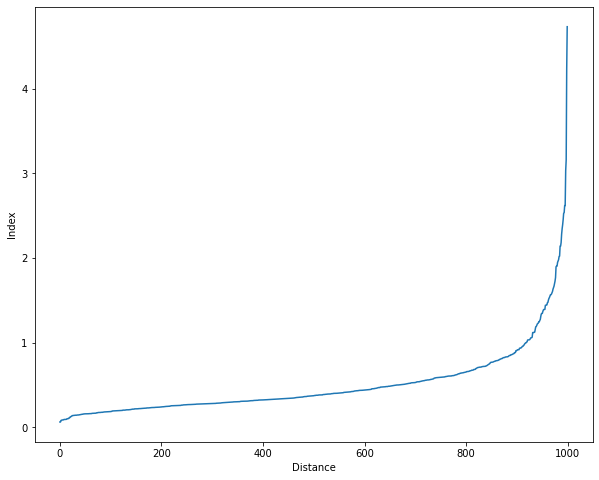

In [ ]:
distances = np.sort(distances , axis = 0)                                             ### plotting the distance to estimate eps and min points for DBSCAN
distances = distances[:,1]
plt.xlabel("Distance")
plt.ylabel("Index")
plt.plot(distances)
plt.show()

In [ ]:
m = DBSCAN(eps = 0.4, min_samples = 5)                                                        ### density based clustering
m.fit(X)

DBSCAN(eps=0.4)

In [ ]:
m.labels_

array([-1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1,  0, -1,
       -1,  0,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0,  0,
        0, -1, -1, -1,  0, -1, -1,  0,  0,  3, -1,  0, -1, -1, -1, -1, -1,
       -1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0,
       -1,  0,  0, -1, -1, -1, -1, -1,  0,  0, -1,  0,  0, -1, -1,  0, -1,
        0, -1, -1, -1,  2, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1,  1,  0, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1,  0, -1,  0,  0, -1, -1,  0,  0,  0, -1, -1, -1,  0,  0,
        0, -1, -1, -1, -1, -1, -1,  0,  2, -1, -1,  0, -1,  0, -1, -1, -1,
        0, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0,  0, -1, -1,  0,  0, -1,
       -1, -1,  0, -1, -1,  0,  0, -1, -1, -1,  0, -1, -1, -1,  0, -1,  0,
        0, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0, -1,
        0, -1,  0, -1, -1

In [ ]:
labels = m.labels_                                                                        ### cluster ID's
print(silhouette_score(X, labels, metric = 'euclidean'))

-0.3095294930951746


In [ ]:
fig = px.scatter_3d(X, x = X[:,0], y=X[:,1], z=X[:,2],                                        ### visualising
              color=labels)
fig.show()

<i> DBSCAN is performing worst than K-means and hierarchical clustering

RFM Hirerchial clustering

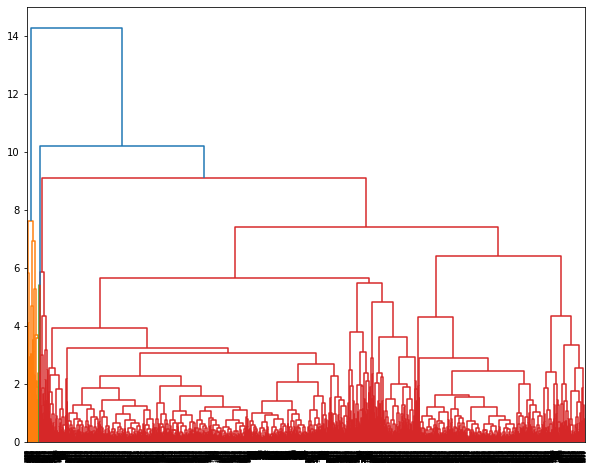

In [ ]:
mergings = linkage(df_rfm, method="complete", metric='euclidean')                                ### max distance between clusters
dendrogram(mergings)
plt.show()

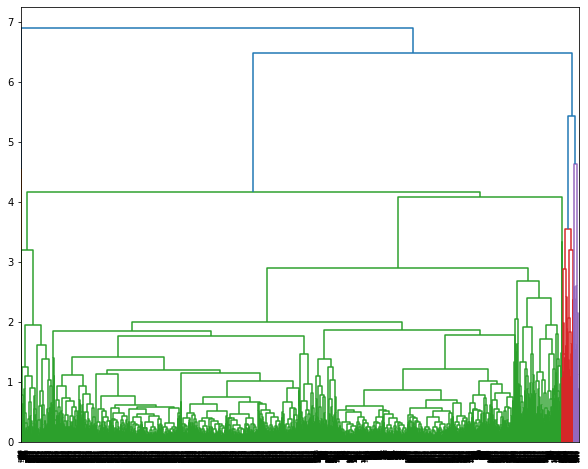

In [ ]:
mergings = linkage(df_rfm, method="average", metric='euclidean')                            ### average distance between clusters
dendrogram(mergings)
plt.show()

In [ ]:
k=3
cluster_labels = cut_tree(mergings, n_clusters=k).reshape(-1, )                                ### reducing dimension by one

In [ ]:
## visualising 3d

fig = px.scatter_3d(df_rfm, x='recen', y='Freq', z='Monetary',
              color=cluster_labels)
fig.show()

In [ ]:
##checking for k=4

k=4
cluster_labels = cut_tree(mergings, n_clusters=k).reshape(-1, )  
fig = px.scatter_3d(df_rfm, x='recen', y='Freq', z='Monetary',
              color=cluster_labels)
fig.show()

In [ ]:
## checking for k = 2
k=2
cluster_labels = cut_tree(mergings, n_clusters=k).reshape(-1, )  
fig = px.scatter_3d(df_rfm, x='recen', y='Freq', z='Monetary',
              color=cluster_labels)
fig.show()

Density based Custering of RFM

In [ ]:
m = DBSCAN(eps = 0.2, min_samples = 3)
m.fit(df_rfm)

DBSCAN(eps=0.2, min_samples=3)

In [ ]:
labels = m.labels_                                                                      ### cluster ID's
print(silhouette_score(df_rfm, labels, metric = 'euclidean'))

-0.3094195516680655


In [ ]:
## Visualising 3d
fig = px.scatter_3d(df_rfm, x='recen', y='Freq', z='Monetary',
              color=labels)
fig.show()

## Conclusion:
* I have arrieved to the conclusion that the best clustering algorithm is k-means.
* The online_retail dataset can be mainly grouped into three clusters.